# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans

In [33]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object


In [34]:
bad_idx = f.index[f.isna().any(axis=1)]
rows_with_na = f[f.isna().any(axis=1)]

# Analyze missing values before dropping
print("=== Missing Values Analysis ===\n")
print(f"Total rows before dropping NA: {len(f)}")

# Count missing values per column
missing_counts = f.isna().sum()
missing_pct = (f.isna().sum() / len(f) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values
})

# Filter to show only columns with missing values
missing_df_filtered = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("\nColumns with missing values:")
print(missing_df_filtered.to_string(index=False))

print(f"\nTotal rows with at least one missing value: {len(bad_idx)}")
print(f"Percentage of rows with missing values: {(len(bad_idx)/len(f)*100):.2f}%")

if len(missing_df_filtered) == 0:
    print("\nNo columns have missing values!")

f = f.dropna()


=== Missing Values Analysis ===

Total rows before dropping NA: 17548339

Columns with missing values:
          Column  Missing Count  Missing %
start_station_id           2497       0.01
  end_station_id           2497       0.01

Total rows with at least one missing value: 2497
Percentage of rows with missing values: 0.01%


In [35]:
f.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                 category
start_station_latitude            float64
start_station_longitude           float64
end_station_id                   category
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                         category
birth_year                          int64
gender                           category
dtype: object

In [36]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548334,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1
17548335,2551,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,3320.0,40.794067,-73.962868,2006.0,40.765909,-73.976342,16390,Customer,1969,0
17548336,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1
17548337,2758,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,3320.0,40.794067,-73.962868,281.0,40.764397,-73.973715,30818,Customer,1969,0


1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

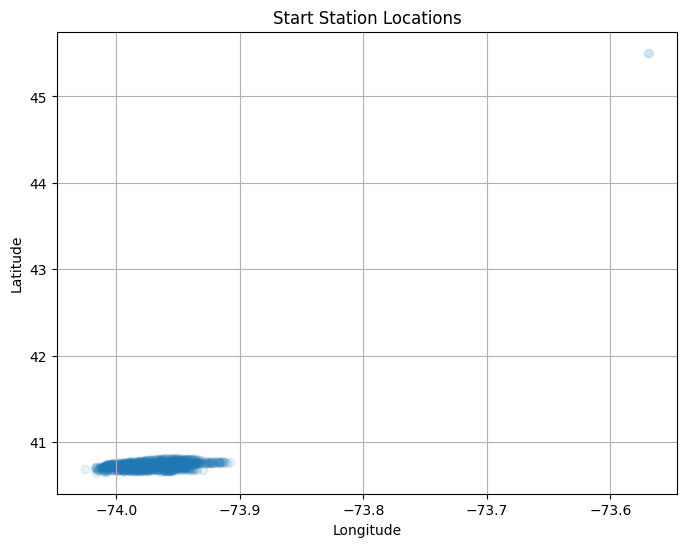

In [37]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [38]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude
676612           3488.0               45.506364               -73.569463
714485           3650.0               45.506264               -73.568906


In [39]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


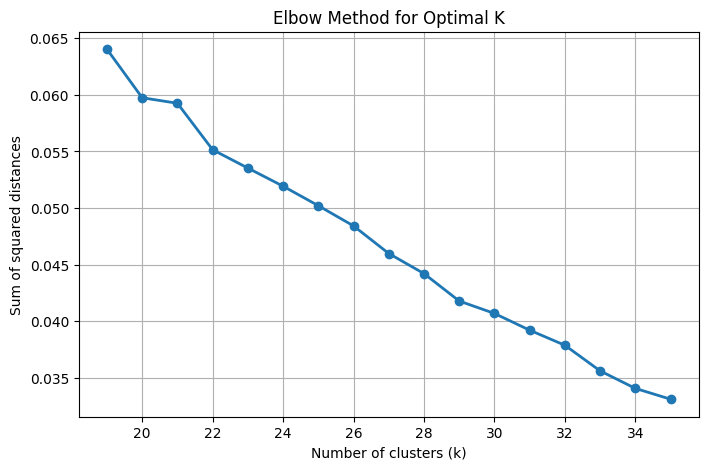

In [40]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

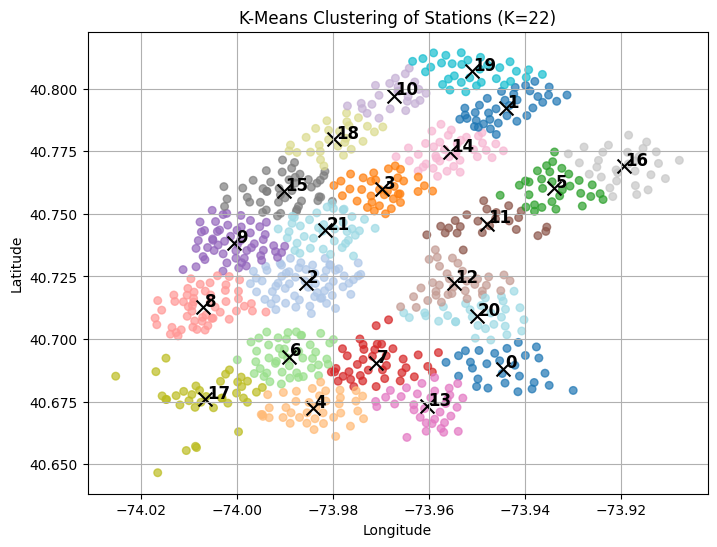

In [41]:
#We observe that k=22 should be a good choice for the number of clusters.

import matplotlib.pyplot as plt

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [42]:
# We want to only look at the clusters that make up the island of Manhattan
# We are only interested in datapoints where either start_station_id or end_station_id is in in one of the clusters

clusters_to_keep = [2,8,9,15,21]

# Normalize dtypes on keys before building merge
f = f.copy()
f['start_station_id'] = f['start_station_id'].astype(str)
f['end_station_id']   = f['end_station_id'].astype(str)

f_cluster = f_cluster.copy()
f_cluster['start_station_id'] = f_cluster['start_station_id'].astype(str)

stations_to_keep = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_keep),
    'start_station_id'
].unique()

f = f[
    f['start_station_id'].isin(stations_to_keep) |
    f['end_station_id'].isin(stations_to_keep)
].copy()


In [43]:
# Add cluster column to original data frame
f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'cluster': 'start_cluster'}),
    on='start_station_id',
    how='left'
)

f = f.merge(
    f_cluster[['start_station_id', 'cluster']]
      .rename(columns={'start_station_id': 'end_station_id', 'cluster': 'end_cluster'}),
    on='end_station_id',
    how='left'
)

for col in ['start_cluster', 'end_cluster']:
    f[col] = pd.to_numeric(f[col], errors='coerce').astype('Int64')

In [44]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,15,21
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,15,15
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,15,15
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,15,15
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11625533,1027,2018-12-31 23:51:13.922,2019-01-01 00:08:21.790,423.0,40.765849,-73.986905,285.0,40.734546,-73.990741,28510,Subscriber,1981,1,15,9
11625534,174,2018-12-31 23:53:59.072,2018-12-31 23:56:53.475,260.0,40.703652,-74.011678,260.0,40.703652,-74.011678,33887,Subscriber,1980,1,8,8
11625535,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1,9,15
11625536,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1,8,8


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

In [45]:
full_idx = pd.date_range(f['starttime'].min().floor('H'),
                         f['starttime'].max().ceil('H'),
                         freq='H')


def hourly_series_from_trips(df, time_col, cluster_col, cluster_id):
    """Return a single hourly Series (DatetimeIndex, freq='h') for one cluster."""
    s = (df.loc[df[cluster_col] == cluster_id, time_col]
           .dt.floor('H')
           .value_counts()
           .sort_index())
    s.index.name = 'timestamp'
    s = s.reindex(full_idx, fill_value=0).astype(int) # keep rows where there are now pickups/dropoffs
    s.name = f'{cluster_col}_{cluster_id}'
    return s

pickup_series  = {c: hourly_series_from_trips(f, 'starttime', 'start_cluster', c)
                  for c in clusters_to_keep}
dropoff_series = {c: hourly_series_from_trips(f, 'stoptime',  'end_cluster',   c)
                  for c in clusters_to_keep}



/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/831590711.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(f['starttime'].min().floor('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/831590711.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f['starttime'].max().ceil('H'),
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/831590711.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, p

In [46]:
dropoff_series[9]

2018-01-01 00:00:00    18
2018-01-01 01:00:00    23
2018-01-01 02:00:00    12
2018-01-01 03:00:00    12
2018-01-01 04:00:00     7
                       ..
2018-12-31 20:00:00    17
2018-12-31 21:00:00     8
2018-12-31 22:00:00    14
2018-12-31 23:00:00     7
2019-01-01 00:00:00     2
Freq: h, Name: end_cluster_9, Length: 8761, dtype: int64

In [47]:
# PICKUPS
pick = (f.loc[f['start_cluster'].isin(clusters_to_keep), ['starttime','start_cluster']]
          .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
          .value_counts(['timestamp','start_cluster'])
          .rename('count')
          .reset_index())

# Build all (timestamp, cluster) combos, then left-join and fill 0
full_pairs = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','start_cluster']
    ).to_frame(index=False)
)

pickup_all = (
    full_pairs.merge(pick, on=['timestamp','start_cluster'], how='left')
              .fillna({'count': 0})
              .astype({'count':'int64'})
              .set_index(['timestamp','start_cluster'])
              .sort_index()
)

# DROPOFFS
drop = (f.loc[f['end_cluster'].isin(clusters_to_keep), ['stoptime','end_cluster']]
          .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
          .value_counts(['timestamp','end_cluster'])
          .rename('count')
          .reset_index())

full_pairs_d = (
    pd.MultiIndex.from_product(
        [full_idx, sorted(clusters_to_keep)],
        names=['timestamp','end_cluster']
    ).to_frame(index=False)
)

dropoff_all = (
    full_pairs_d.merge(drop, on=['timestamp','end_cluster'], how='left')
                .fillna({'count': 0})
                .astype({'count':'int64'})
                .set_index(['timestamp','end_cluster'])
                .sort_index()
)


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/1095759283.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['starttime'].dt.floor('H'))
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/1095759283.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .assign(timestamp=lambda x: x['stoptime'].dt.floor('H'))


In [48]:
f

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_cluster,end_cluster
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,15,21
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,15,15
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,15,15
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,15,15
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,15,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11625533,1027,2018-12-31 23:51:13.922,2019-01-01 00:08:21.790,423.0,40.765849,-73.986905,285.0,40.734546,-73.990741,28510,Subscriber,1981,1,15,9
11625534,174,2018-12-31 23:53:59.072,2018-12-31 23:56:53.475,260.0,40.703652,-74.011678,260.0,40.703652,-74.011678,33887,Subscriber,1980,1,8,8
11625535,734,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,336.0,40.730477,-73.999061,379.0,40.749156,-73.991600,27111,Subscriber,1986,1,9,15
11625536,2376,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,427.0,40.701907,-74.013942,259.0,40.701221,-74.012342,34398,Subscriber,1979,1,8,8


In [49]:
train_end = pd.Timestamp('2018-10-31 23:00:00')
test_start = pd.Timestamp('2018-11-01 00:00:00')

In [50]:
def make_nextday_lag24_dataset(s: pd.Series, horizon: int = 24):
    """
    Build a supervised dataset with only the last 24 hourly lags.
    One row per day at 23:00, targets are the next day's 24 hours.
    """
    s = s.asfreq('H').fillna(0).astype(float)
    df = pd.DataFrame({'y': s})

    for L in range(1, 25):
        df[f'lag_{L:02d}'] = df['y'].shift(L)

    # +1 weekly lag
    df['lag_168'] = df['y'].shift(168)

    df['DOW'] = df.index.dayofweek.astype('int8')
    df['hour'] = df.index.hour.astype('int8')       # 0..23

    for h in range(1, horizon + 1):
        df[f'y_tplus{h:02d}'] = df['y'].shift(-h)

    # keep only end-of-day rows (23:00)
    eod = (df.index.hour == 23)

    X = df.loc[eod, [f'lag_{L:02d}' for L in range(1, 25)] + ['lag_168', 'DOW', 'hour']]
    Y = df.loc[eod, [f'y_tplus{h:02d}' for h in range(1, horizon + 1)]]

    # drop rows with NaNs from edges
    mask = ~(X.isna().any(axis=1) | Y.isna().any(axis=1))
    X, Y = X.loc[mask], Y.loc[mask]

    # split by calendar
    train_mask = X.index <= train_end
    Xtr, Ytr = X.loc[train_mask], Y.loc[train_mask]
    Xte, Yte = X.loc[~train_mask], Y.loc[~train_mask]
    return Xtr, Ytr, Xte, Yte

In [51]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer

In [52]:
def fit_gbr_24lags(s: pd.Series):
    """
    Fit GradientBoosting to predict next-day 24 hours.
    """
    Xtr, Ytr, Xte, Yte = make_nextday_lag24_dataset(s)

    num_cols = [c for c in Xtr.columns if c.startswith('lag_')]
    cat_cols = ['DOW', 'hour']

    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])

    base = GradientBoostingRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=2,
        subsample=0.7, random_state=42, loss='huber'
    )

    model = Pipeline([('pre', pre), ('est', MultiOutputRegressor(base))])
    model.fit(Xtr, Ytr)
    
    Yhat = model.predict(Xte)  # shape: [n_test_days, 24]

    # metrics
    rmse_per_h = np.sqrt(((Yhat - Yte.values) ** 2).mean(axis=0))
    scores = {
        'MAE_mean': mean_absolute_error(Yte.values.flatten(), Yhat.flatten()),
        'RMSE_mean': rmse_per_h.mean(),
        'RMSE_per_hour': rmse_per_h,
        'n_test_days': len(Xte)
    }
    return model, (Xtr, Ytr, Xte, Yte, Yhat, scores)

In [53]:
models_pick, eval_pick = {}, {}
models_drop, eval_drop = {}, {}

for c in clusters_to_keep:
    # Pickups
    m_p, (Xtr_p, Ytr_p, Xte_p, Yte_p, Yhat_p, sc_p) = fit_gbr_24lags(pickup_series[c])
    models_pick[c] = m_p
    eval_pick[c]   = {'Xtr': Xtr_p, 'Ytr': Ytr_p, 'Xte': Xte_p, 'Yte': Yte_p, 'Yhat': Yhat_p, 'scores': sc_p}

    # Dropoffs
    m_d, (Xtr_d, Ytr_d, Xte_d, Yte_d, Yhat_d, sc_d) = fit_gbr_24lags(dropoff_series[c])
    models_drop[c] = m_d
    eval_drop[c]   = {'Xtr': Xtr_d, 'Ytr': Ytr_d, 'Xte': Xte_d, 'Yte': Yte_d, 'Yhat': Yhat_d, 'scores': sc_d}


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/201153247.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/201153247.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/201153247.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/201153247.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.asfreq('H').fillna(0).astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/201153247.py:6: FutureWarning: 'H' is depre

In [54]:
eval_pick[15]['scores'], eval_drop[15]['scores']

({'MAE_mean': 54.78523261686489,
  'RMSE_mean': np.float64(72.86472862187327),
  'RMSE_per_hour': array([ 12.13885046,   8.04165484,   6.14145941,   4.11529952,
           6.16115869,  23.08957211,  80.92468569, 104.40227333,
         176.28519507, 123.45753699,  59.31735905,  60.24780766,
          58.50636897,  66.46399295,  68.11296504,  85.65780985,
         119.80957356, 204.880879  , 190.29603083, 112.32426381,
          67.05666836,  49.2231516 ,  37.53423014,  24.56470002]),
  'n_test_days': 60},
 {'MAE_mean': 55.178831343432975,
  'RMSE_mean': np.float64(74.66892251818604),
  'RMSE_per_hour': array([ 10.91155326,   7.57714694,   5.26512294,   3.91439816,
           4.90568606,  10.39060598,  42.46171472,  88.56850967,
         161.78838145, 133.64737063,  62.95000121,  58.02358113,
          65.76601025,  78.28246194,  83.35223711, 107.12112062,
         155.97877503, 229.24666404, 194.78187935, 120.8436729 ,
          65.52421103,  44.55700477,  32.05097239,  24.14505885]),
 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rebuild_hourly_from_nextday(eval_entry: dict, base_series: pd.Series) -> tuple[pd.Series, pd.Series]:
    """
    Take one eval_*[cluster] entry and the original hourly base_series (pickups or dropoffs),
    and return two aligned hourly Series: y_true_hourly, y_pred_hourly over the Nov–Dec test span.
    """
    # Each row in Xte index is the *origin* at 23:00 of day D (end-of-day).
    # The prediction Yhat[i] is for the next day: hours D+1 00:00..23:00.
    origins = pd.DatetimeIndex(eval_entry['Xte'].index)  # 23:00 timestamps
    yhat    = np.asarray(eval_entry['Yhat'])             # shape [n_days, 24]
    yte     = np.asarray(eval_entry['Yte'].values)       # shape [n_days, 24]

    pred_idx_all = []
    pred_vals_all = []
    true_vals_all = []

    for i, origin in enumerate(origins):
        day_start = (origin + pd.Timedelta(hours=1)).floor('D')  # next day 00:00
        idx_24 = pd.date_range(day_start, periods=24, freq='H')

        pred_idx_all.append(idx_24)
        pred_vals_all.append(yhat[i])
        true_vals_all.append(yte[i])

    pred_idx_all = pd.DatetimeIndex(np.concatenate(pred_idx_all))
    y_pred_hourly = pd.Series(np.concatenate(pred_vals_all), index=pred_idx_all, name='yhat')
    y_true_hourly = pd.Series(np.concatenate(true_vals_all), index=pred_idx_all, name='ytrue')

    # (Optional) sanity align with the original hourly series (keeps only test hours)
    start, end = pred_idx_all.min(), pred_idx_all.max()
    base_slice = base_series.asfreq('H').loc[start:end].astype(float)
    # Ensure same index:
    y_true_hourly = base_slice.reindex(y_true_hourly.index, fill_value=0)  # replace with base truth if you prefer

    return y_true_hourly, y_pred_hourly


In [56]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

def eval_train_test_with_teacher_fn(model, eval_entry, title_prefix=""):
    """
    model: your fitted pipeline (e.g., models_pick[c])
    eval_entry: e.g., eval_pick[c] with keys Xtr,Ytr,Xte,Yte,Yhat
    Prints train and test stats using your teacher's print_stats on flattened arrays.
    Returns a dict with the 6 metrics to optionally show on plots.
    """
    # train
    Ytr_true = eval_entry['Ytr'].values
    Ytr_pred = model.predict(eval_entry['Xtr'])
    print_stats(Ytr_true.flatten(), Ytr_pred.flatten(), title=f"{title_prefix} TRAIN")

    # test
    Yte_true = eval_entry['Yte'].values
    Yte_pred = eval_entry['Yhat']
    print_stats(Yte_true.flatten(), Yte_pred.flatten(), title=f"{title_prefix} TEST")

    return {
        'train': {
            'R2':  r2_score(Ytr_true.flatten(), Ytr_pred.flatten()),
            'MAE': mean_absolute_error(Ytr_true.flatten(), Ytr_pred.flatten()),
            'MAPE': mean_absolute_percentage_error(Ytr_true.flatten(), Ytr_pred.flatten())
        },
        'test': {
            'R2':  r2_score(Yte_true.flatten(), Yte_pred.flatten()),
            'MAE': mean_absolute_error(Yte_true.flatten(), Yte_pred.flatten()),
            'MAPE': mean_absolute_percentage_error(Yte_true.flatten(), Yte_pred.flatten())
        }
    }


In [57]:
# Code from week 7 blabla
def plotprediction(series, pred_series, metrics, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])
    plt.legend(loc="upper right")
    plt.grid(True)
    
    ax = plt.gca()
    ax.text(0.01, 0.95, "\n".join(metrics),
            transform=ax.transAxes, ha="left", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.75))
    plt.tight_layout()
    # Plot confidence intervals for smoothed values
    plt.show()

In [58]:

eval_pick[2]['scores'], eval_drop[2]['scores']


({'MAE_mean': 56.859021506990835,
  'RMSE_mean': np.float64(77.2214725427114),
  'RMSE_per_hour': array([ 17.68187017,  13.67442662,  10.19750208,   7.06222481,
           5.11995572,  11.37519357,  44.63442673, 103.03389976,
         196.90335455, 101.20823318,  72.58032177,  74.86047399,
          79.6666176 ,  81.80875866,  86.45486721, 104.29800767,
         118.84601361, 152.43771842, 173.37334959, 145.98240316,
          98.87252752,  70.70173946,  47.2478526 ,  35.29360256]),
  'n_test_days': 60},
 {'MAE_mean': 61.10163898546793,
  'RMSE_mean': np.float64(80.66205597252481),
  'RMSE_per_hour': array([ 18.16976651,  11.68547474,   9.38482966,   6.70775234,
           5.2572751 ,   7.01708461,  27.06816277,  53.73368601,
          87.95916309,  69.72817905,  63.01467722,  71.88374068,
          77.47755524,  89.15992773,  93.32121053, 111.94400007,
         128.93762959, 212.86661717, 264.17093582, 203.56894996,
         135.63432388,  84.52388814,  63.26210373,  39.41240968]),
  

Pickups cluster 2 TRAIN: 
	r^2=0.962887
	MAE=22.454661
	MAPE=inf
Pickups cluster 2 TEST: 
	r^2=0.718416
	MAE=56.859022
	MAPE=61.851857
Dropoff cluster 2 TRAIN: 
	r^2=0.965703
	MAE=23.018340
	MAPE=inf
Dropoff cluster 2 TEST: 
	r^2=0.641130
	MAE=61.101639
	MAPE=57.078604


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3243000186.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_24 = pd.date_range(day_start, periods

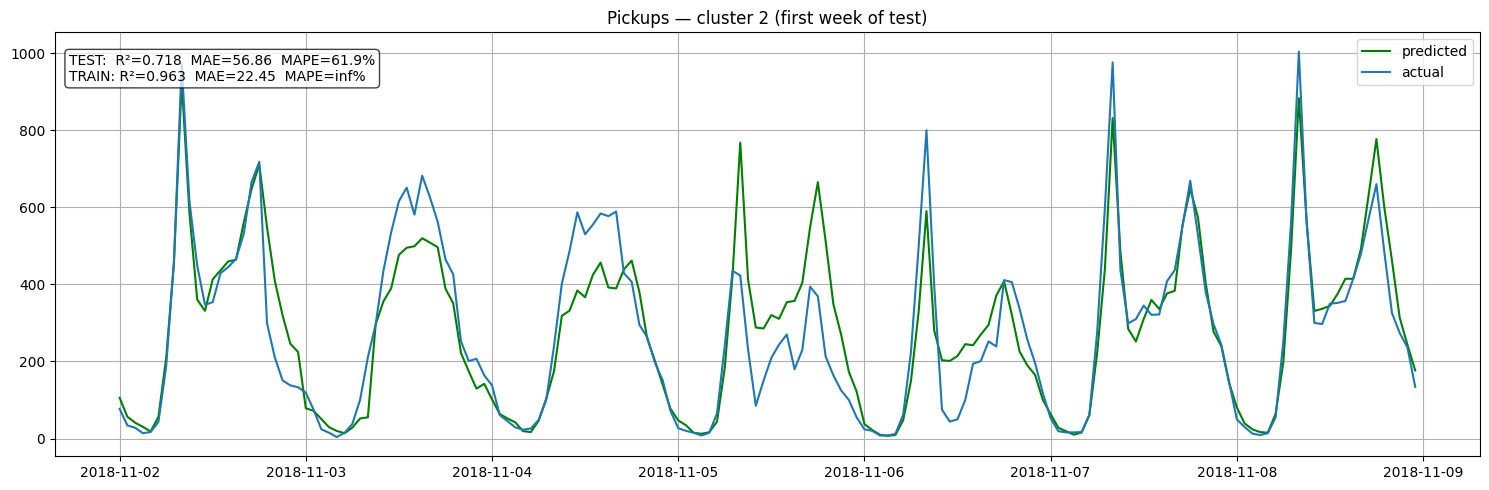

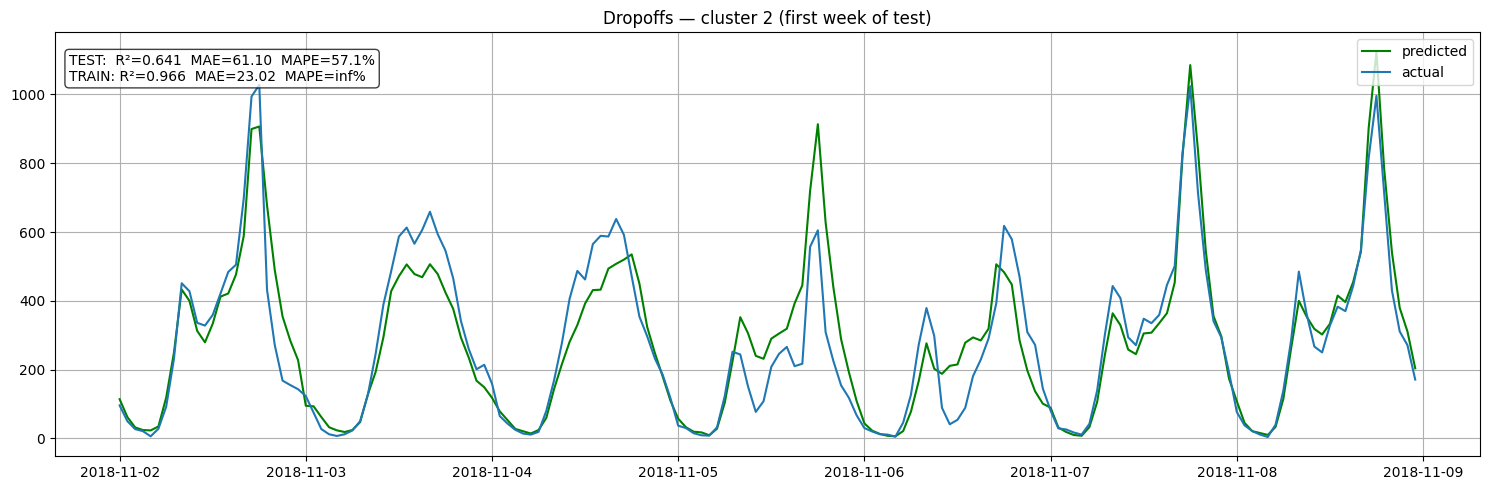

Pickups cluster 8 TRAIN: 
	r^2=0.962320
	MAE=22.157873
	MAPE=inf
Pickups cluster 8 TEST: 
	r^2=0.493884
	MAE=54.040422
	MAPE=inf
Dropoff cluster 8 TRAIN: 
	r^2=0.962840
	MAE=21.556184
	MAPE=inf
Dropoff cluster 8 TEST: 
	r^2=0.686022
	MAE=48.886884
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

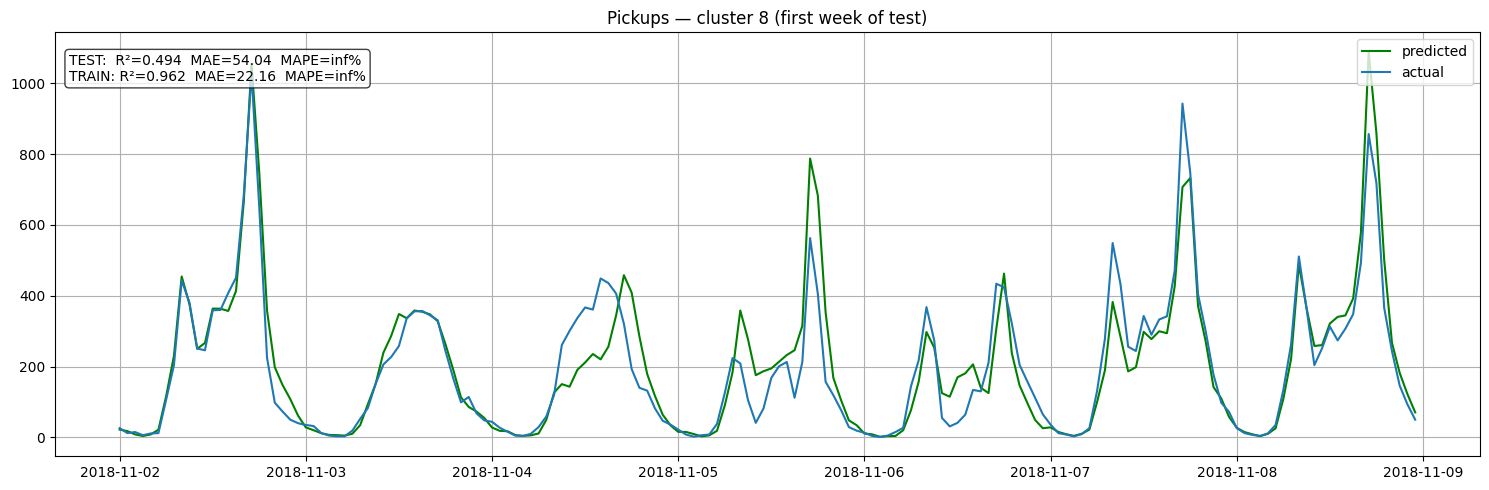

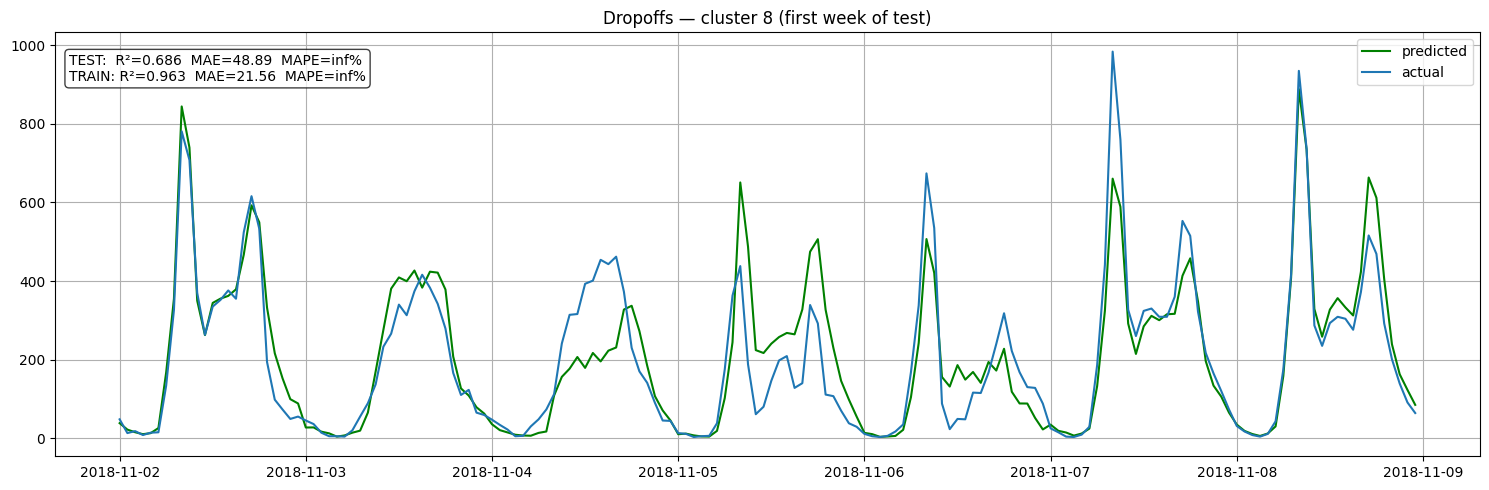

Pickups cluster 9 TRAIN: 
	r^2=0.960922
	MAE=29.535319
	MAPE=inf
Pickups cluster 9 TEST: 
	r^2=0.669335
	MAE=70.390290
	MAPE=74.312769


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Dropoff cluster 9 TRAIN: 
	r^2=0.959682
	MAE=29.535178
	MAPE=inf
Dropoff cluster 9 TEST: 
	r^2=0.676611
	MAE=72.587568
	MAPE=75.438736


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3243000186.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_24 = pd.date_range(day_start, periods=24, freq='H')
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3243000186.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  base_slice = base_series.asfreq('H').loc[start:end].astype(float)
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3243000186.py:22: FutureWarning: 'H' is deprecated and will

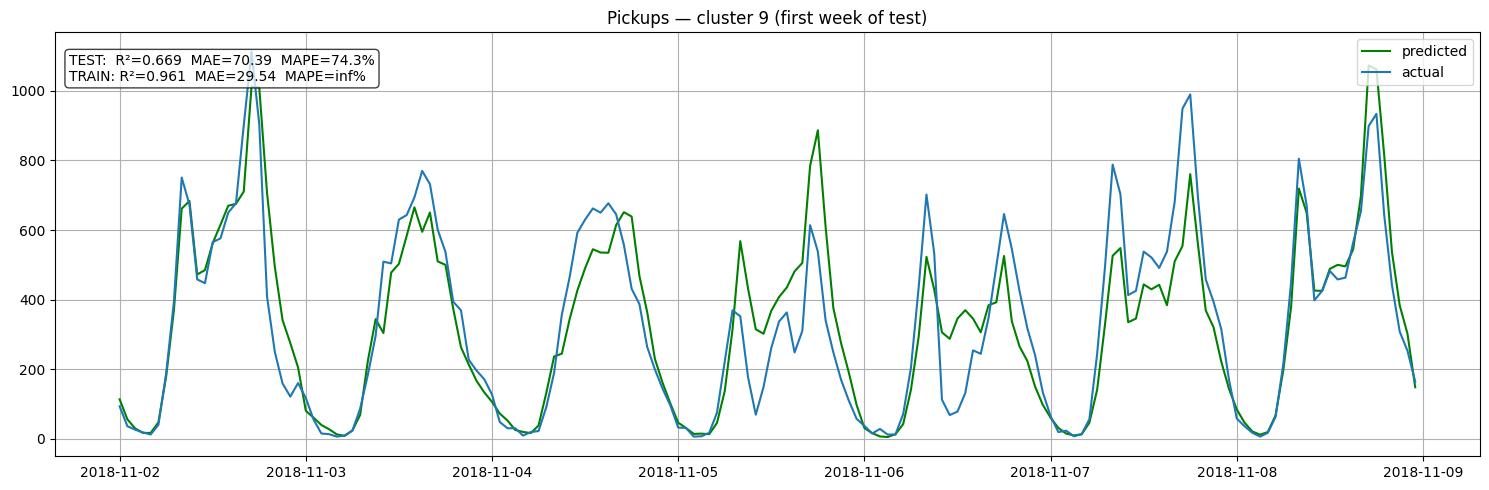

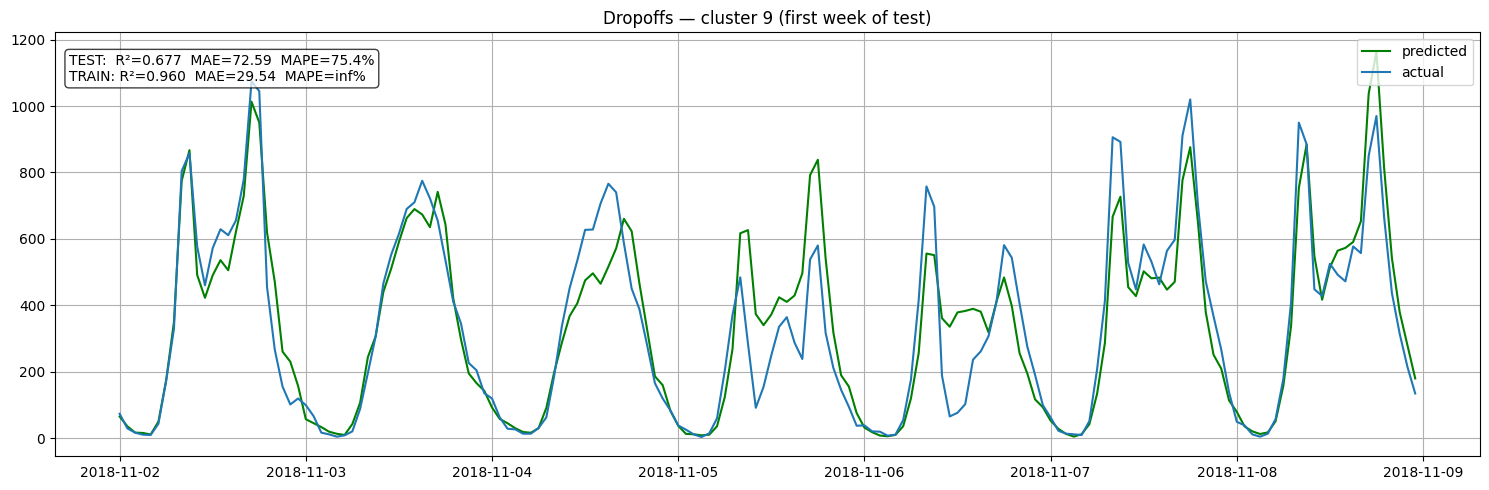

Pickups cluster 15 TRAIN: 
	r^2=0.958107
	MAE=21.789047
	MAPE=inf
Pickups cluster 15 TEST: 
	r^2=0.672329
	MAE=54.785233
	MAPE=inf
Dropoff cluster 15 TRAIN: 
	r^2=0.964351
	MAE=21.018742
	MAPE=inf
Dropoff cluster 15 TEST: 
	r^2=0.665085
	MAE=55.178831
	MAPE=inf
	r^2=0.958107
	MAE=21.789047
	MAPE=inf
Pickups cluster 15 TEST: 
	r^2=0.672329
	MAE=54.785233
	MAPE=inf
Dropoff cluster 15 TRAIN: 
	r^2=0.964351
	MAE=21.018742
	MAPE=inf
Dropoff cluster 15 TEST: 
	r^2=0.665085
	MAE=55.178831
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

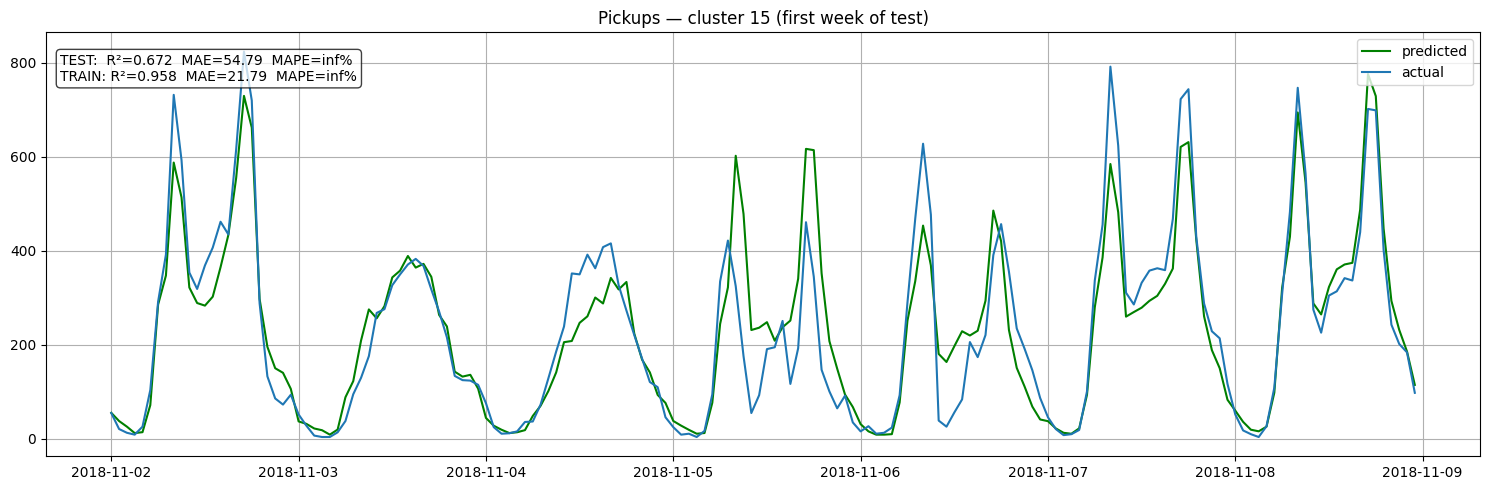

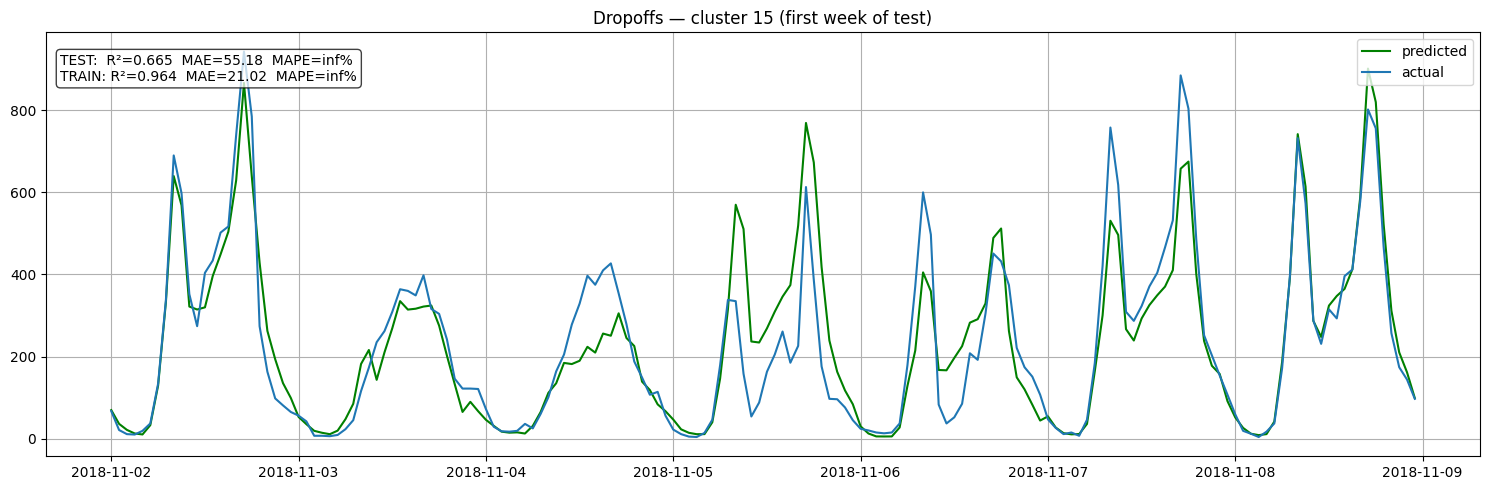

Pickups cluster 21 TRAIN: 
	r^2=0.964873
	MAE=21.301026
	MAPE=inf
Pickups cluster 21 TEST: 
	r^2=0.678280
	MAE=58.053491
	MAPE=78.130526
Dropoff cluster 21 TRAIN: 
	r^2=0.963115
	MAE=20.329546
	MAPE=inf
Dropoff cluster 21 TEST: 
	r^2=0.685889
	MAE=59.387548
	MAPE=inf


/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545vycfpjds_1r0000gn/T/ipykernel_49164/3803377121.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/var/folders/3b/_701tnqj0_545v

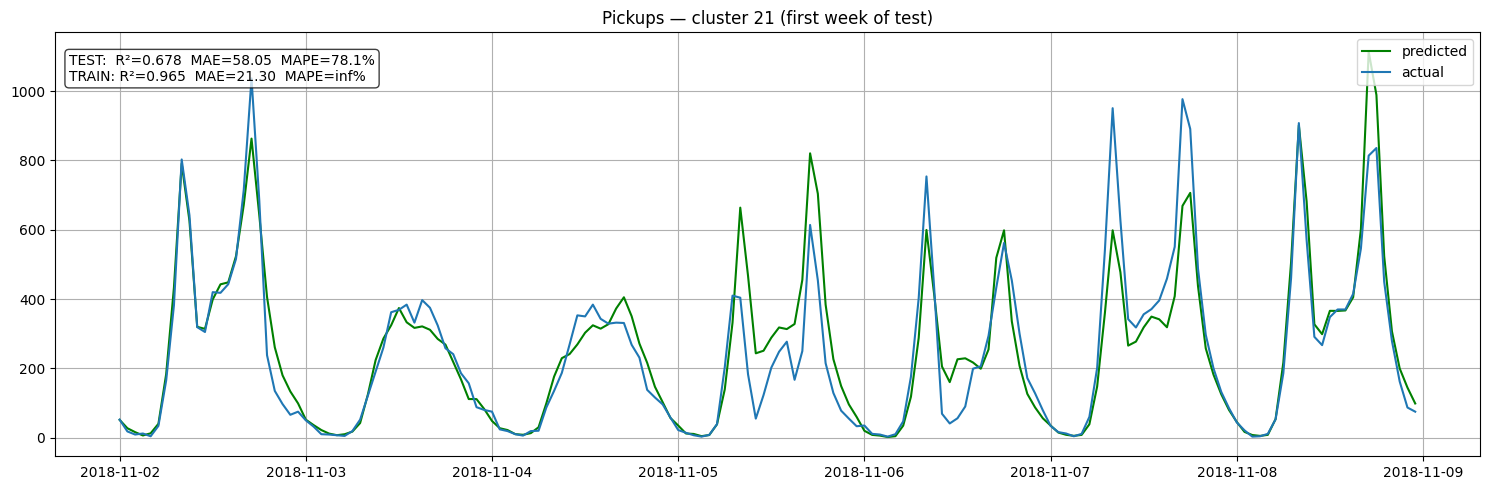

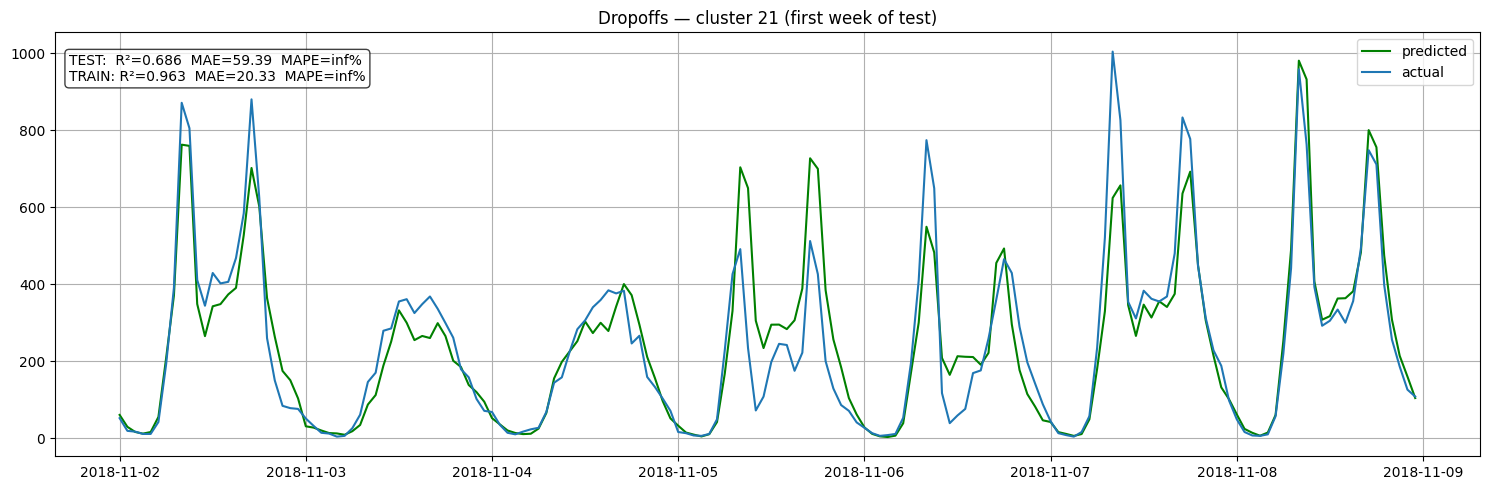

In [59]:
eval_pick[15]['scores'], eval_drop[15]['scores']

# Pick a 168h window starting at the first predicted hour in test
for c in clusters_to_keep:
    if c not in eval_pick or c not in eval_drop:
        print(f"Skipping cluster {c}: missing eval data.")
        continue
    metrics_p = eval_train_test_with_teacher_fn(models_pick[c], eval_pick[c], title_prefix=f"Pickups cluster {c}")
    metrics_d = eval_train_test_with_teacher_fn(models_drop[c], eval_drop[c], title_prefix=f"Dropoff cluster {c}")
    # Rebuild hourly actual vs predicted
    y_true_p, y_pred_p = rebuild_hourly_from_nextday(eval_pick[c], pickup_series[c])
    y_true_d, y_pred_d = rebuild_hourly_from_nextday(eval_drop[c],  dropoff_series[c])

    # First 168 hours (one week) in the test span
    idx_p = y_true_p.index[:168]
    txt_p = [
        f"TEST:  R²={metrics_p['test']['R2']:.3f}  MAE={metrics_p['test']['MAE']:.2f}  MAPE={metrics_p['test']['MAPE']:.1f}%",
        f"TRAIN: R²={metrics_p['train']['R2']:.3f}  MAE={metrics_p['train']['MAE']:.2f}  MAPE={metrics_p['train']['MAPE']:.1f}%"
    ]
    plotprediction(series=y_true_p.loc[idx_p],
                   pred_series=y_pred_p.loc[idx_p],
                   metrics=txt_p,
                   labels=["actual", "predicted"],
                   title=f"Pickups — cluster {c} (first week of test)")

    idx_d = y_true_d.index[:168]
    txt_d = [
        f"TEST:  R²={metrics_d['test']['R2']:.3f}  MAE={metrics_d['test']['MAE']:.2f}  MAPE={metrics_d['test']['MAPE']:.1f}%",
        f"TRAIN: R²={metrics_d['train']['R2']:.3f}  MAE={metrics_d['train']['MAE']:.2f}  MAPE={metrics_d['train']['MAPE']:.1f}%"
    ]
    plotprediction(series=y_true_d.loc[idx_d],
                   pred_series=y_pred_d.loc[idx_d],
                   metrics=txt_d,
                   labels=["actual", "predicted"],
                   title=f"Dropoffs — cluster {c} (first week of test)")


In [60]:
# Error

3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.